# Using RoBERTa with Fastai - ReCoRD

In [1]:
from fastai.text import *
from fastai.metrics import *
from pytorch_transformers import RobertaTokenizer
import jsonlines

In [2]:
# Creating a config class to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [3]:
# defining our configuration

config = Config(
    task = "ReCoRD",
#     remove_percent = None, # Set to a num between 0 and 1 to remove num% from training ds (for quicker training)
    remove_percent = .4, # Set to None if not testing other this percetage will be removed from training ds
    undersample = True, # will fix the class imbalance by undersampling
    seq_len_check = True, # will remove all inputs over the max seq length (as opposed to truncating them)
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchanged with roberta-large 
    pad_idx = 0,
    max_lr=1e-5,
    epochs=2,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 3,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
    mask_tok = "<mask>",
    mark_fields=True,
)

In [4]:
path = Path(".")
data_path = path/"data"

In [5]:
#load json object
def record_parser(path_to_json, test=False):
    with jsonlines.open(path_to_json) as f:
        idx,passage,question,entity,label = [],[],[],[],[]
        for obj in f:
            text = obj["passage"]["text"]
            for q in obj['qas']:
                if not test: answers = [a["text"] for a in q["answers"]] 
                for e in obj["passage"]["entities"]:
                    idx.append(obj["idx"])
                    passage.append(text)
                    ques = q["query"]#.replace("@placeholder",config.mask_tok)
                    question.append(ques)
                    ent = text[e["start"]:e["end"]+1]
                    entity.append(ent)
                    label.append(ent in answers) if not test else label.append(None)
    return pd.DataFrame({"idx":idx,"passage":passage,"question":question,"entity":entity,"label":label})

In [6]:
train = record_parser(data_path/config.task/"train.jsonl")
val = record_parser(data_path/config.task/"val.jsonl")
test = record_parser(data_path/config.task/"test.jsonl",test=True)

In [7]:
train.head()

,idx,passage,question,entity,label
0,0,The harrowing stories of women and children lo...,The baby she gave birth to is her husbands and...,Afghanistan,False
1,0,The harrowing stories of women and children lo...,The baby she gave birth to is her husbands and...,Mariam,False
2,0,The harrowing stories of women and children lo...,The baby she gave birth to is her husbands and...,Badam Bagh,False
3,0,The harrowing stories of women and children lo...,The baby she gave birth to is her husbands and...,Nuria,True
4,0,The harrowing stories of women and children lo...,The baby she gave birth to is her husbands and...,Nuria,True


In [8]:
train.passage[0]

"The harrowing stories of women and children locked up for so-called 'moral crimes' in Afghanistan's notorious female prison have been revealed after cameras were allowed inside. Mariam has been in Badam Bagh prison for three months after she shot a man who just raped her at gunpoint and then turned the weapon on herself - but she has yet to been charged. Nuria has eight months left to serve of her sentence for trying to divorce her husband. She gave birth in prison to her son and they share a cell together. Scroll down for video Nuria was jailed for trying to divorce her husband. Her son is one of 62 children living at Badam Bagh prison\n@highlight\nMost of the 202 Badam Bagh inmates are jailed for so-called 'moral crimes'\n@highlight\nCrimes include leaving their husbands or refusing an arrange marriage\n@highlight\n62 children live there and share cells with their mothers and five others"

In [9]:
train.question[0]

'The baby she gave birth to is her husbands and he has even offered to have the courts set her free if she returns, but @placeholder has refused.'

In [10]:
train.label.value_counts()

False    1537301
True      259555
Name: label, dtype: int64

In [11]:
feat_cols = ["question","passage","entity"]
label_cols = "label"

## Setting Up the Tokenizer

In [12]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        if config.mark_fields:
            sub = 2 # subtraction in totoal seq_length to be made due to adding spcl tokens
            assert "xxfld" in t
            t = t.replace("xxfld 1","") # remove the xxfld 1 special token from fastai
            # converting fastai field sep token to Roberta
            t = re.split(r'xxfld \d+', t) 
            res = []
            for i in range(len(t)-1): # loop over the number of additional fields and the Roberta sep
                res += self._pretrained_tokenizer.tokenize(t[i]) + [config.end_tok]
                sub += 1 # increase our subtractions since we added more spcl tokens
            res += self._pretrained_tokenizer.tokenize(t[-1]) # add the last sequence
            return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok] 
        
        res = self._pretrained_tokenizer.tokenize(t)
        return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok]

In [13]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [14]:
# create fastai vocabulary for roberta
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [15]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False, mark_fields=config.mark_fields)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Accounting for DF Size and Sequence Length

In [16]:
from imblearn.under_sampling import RandomUnderSampler
def undersample(df):
    rus = RandomUnderSampler(random_state=config.seed)
    X_train, y_train = rus.fit_resample(df[feat_cols], df[label_cols])
    res = pd.DataFrame(X_train)
    res["label"] = y_train
    res.columns = df[["question","passage","entity"]+[label_cols]].columns
    return res

In [17]:
if config.undersample: train = undersample(train)

In [18]:
# reduce df sizes if testing

np.random.seed(config.seed)
    
if config.remove_percent: # if testing
    print(int(train.shape[0]*config.remove_percent), "of the training dataset is removed")
    
    remove_percent = config.remove_percent
    train_drop_indices = np.random.choice(train.index, int(train.shape[0]*remove_percent), replace=False)
    train.drop(train_drop_indices, inplace=True)
    
    val_drop_indices = np.random.choice(val.index, int(val.shape[0]*remove_percent), replace=False)
    val.drop(val_drop_indices, inplace=True)
    
    test_drop_indices = np.random.choice(test.index, int(test.shape[0]*remove_percent), replace=False)
    test.drop(test_drop_indices, inplace=True)

207644 of the training dataset is removed


In [19]:
def seq_len_check(row):
    seq_len = 1
    for c in feat_cols:
        seq_len += len(roberta_tok.tokenize(str(row[c]))) + 1    
    return seq_len < (config.max_seq_len - 3)

In [20]:
train.shape

(311466, 4)

In [ ]:
if config.seq_len_check:
    train_in_range = train.apply(seq_len_check,axis=1)
    val_in_range = val.apply(seq_len_check,axis=1)
    test_in_range = test.apply(seq_len_check,axis=1)

    print("dropping {} out of {} questions in train".format(sum(~train_in_range),len(train)))
    print("dropping {} out of {} questions in val".format(sum(~val_in_range),len(val)))
    print("dropping {} out of {} questions in test".format(sum(~test_in_range),len(test)))

    train = train[train_in_range]
    val = val[val_in_range]
    test = test[test_in_range]

In [ ]:
# randomizing the order of training and val data
train = train.sample(frac=1,random_state = config.seed).reset_index(drop=True)
val = val.sample(frac=1,random_state = config.seed).reset_index(drop=True)


In [ ]:
train.head()

In [ ]:
train.label.value_counts()

## Loading from CSVs (.4 remove percent)

In [48]:
train.isna().any()

question    False
passage     False
entity       True
label       False
dtype: bool

In [41]:
train.to_csv(data_path/config.task/"train.csv",index=False)
val.to_csv(data_path/config.task/"val.csv",index=False)
test.to_csv(data_path/config.task/"test.csv",index=False)

In [42]:
train = pd.read_csv(data_path/config.task/"train.csv")
val = pd.read_csv(data_path/config.task/"val.csv")
test = pd.read_csv(data_path/config.task/"test.csv")

In [51]:
train.dropna(inplace=True)
val.dropna(inplace=True)
test.dropna(inplace=True)

## Setting up the DataBunch

In [52]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [53]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [54]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = ItemLists(".", RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor),
                      RobertaTextList.from_df(val, ".", cols=feat_cols, processor=processor)
                ) \
       .label_from_df(cols=label_cols, label_cls=CategoryList) \
       .add_test(RobertaTextList.from_df(test, ".", cols=feat_cols, processor=processor)) \
       .databunch(bs=config.bs,pad_first=False)

# Building the Model

In [55]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaForSequenceClassification

# defining our model architecture 
class RobertaForSequenceClassificationModel(nn.Module):
    def __init__(self,num_labels=config.num_labels):
        super(RobertaForSequenceClassificationModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaForSequenceClassification.from_pretrained(config.roberta_model_name,num_labels= self.num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = outputs[0] 
        return logits

In [56]:
def f_score(input,target,eps:float=1e-9):
    n = target.shape[0]
    input = input.argmax(dim=-1).view(n,-1).float()
    target = target.view(n,-1).float()
    TP = (input*target).sum(0)
    prec = TP / (input.sum(0)+eps)
    rec = TP / (target.sum(0)+eps)
    f1 = (2*prec*rec)/(prec+rec+eps)
    return f1

In [57]:
roberta_model = RobertaForSequenceClassificationModel()

learn = Learner(data, roberta_model, metrics=[accuracy, f_score])

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

# Getting Untrained Predictions

In [58]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [59]:
# what % of the train labels are False
(train.label==False).mean()

0.4863387519312152

In [60]:
# what % of the val labels are False
(val.label==False).mean()

0.8120193016836293

In [77]:
# val preds
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)
# accuracy for valid with untrained model
(pred_values == data.valid_ds.y.items).mean()

# Running the model

In [62]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.327451,0.392896,0.831995,0.229506,3:20:41
1,0.177669,0.300788,0.889500,0.235516,3:20:35


# Interpretations

In [64]:
# interpreting training results
interp_train = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

In [ ]:
interp_train.plot_confusion_matrix()

In [ ]:
# train accuracy
conf_mat = interp_train.confusion_matrix()
(conf_mat[0,0] + conf_mat[1,1]) / conf_mat.sum()

In [65]:
# interpreting validation results
interp = ClassificationInterpretation.from_learner(learn)

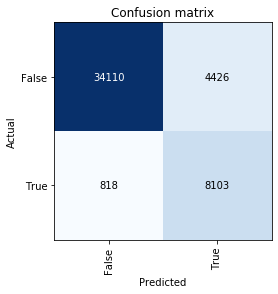

In [66]:
interp.plot_confusion_matrix()

# Getting Predictions

In [80]:
def summarize(conf_mat):
    acc = (conf_mat[0,0] + conf_mat[1,1]) / conf_mat.sum()
    rec = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1]) # TP / TP + FN
    prec = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0]) # TP / TP + FP
    f1 = 2*rec*prec/(rec+prec)
    print(f"acc: {acc}, recall: {rec}, precision: {prec}, f1: {f1}")
    

In [81]:
summarize(interp.confusion_matrix())

acc: 0.8894999683924395, recall: 0.6467395642110304, precision: 0.9083062436946531, f1: 0.7555244755244755


In [ ]:
# val preds
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [ ]:
# accuracy for valid 
(pred_values == data.valid_ds.y.items).mean()

In [ ]:
# test preds
test_preds, test_pred_values = get_preds_as_nparray(DatasetType.Test)